In [1]:
using LinearAlgebra
using Optim
using Plots
using Optim
using LineSearches

# Switch to choose between Float64 and BigFloat
use_bigfloat = true


###########################################################################################
# Custom factorial
###########################################################################################

# Custom factorial function for BigFloat
function factorial_big(x::BigFloat)
    if x == BigFloat(0)
        return BigFloat(1.0)
    else
        return x * factorial_big(x - BigFloat(1))
    end
end

# Custom factorial function for Float64
function factorial_float(x::Float64)
    if x == 0.0
        return 1.0
    else
        return x * factorial_float(x - 1.0)
    end
end

# Factorial function based on switch
factorial(x) = use_bigfloat ? factorial_big(BigFloat(x)) : factorial_float(Float64(x))
###########################################################################################


# Set up the points with BigFloat or Float64
p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

m1 = (p2 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m2 = (p1 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m3 = (p1 .+ p2) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)

b = (p1 .+ p2 .+ p3) ./ (use_bigfloat ? BigFloat(3.0) : 3.0)

# vertices
T1 = hcat(p1, p2, p3)
eval_T1(i, j) = T1[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T1[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(i, j) = T2[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T2[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# midpoint
T3 = hcat(b)
eval_T3(i, j) = T3[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T3[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

eval_T4(a, i, j) = T4(a)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T4(a)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1, 
             a * m2 .+ (1 .- a) * p2, 
             a * m3 .+ (1 .- a) * p3)

eval_T5(a, i, j) = T5(a)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T5(a)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# inner class, type 2
T6(a, b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

eval_T6(a, b, i, j) = T6(a, b)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T6(a, b)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# Integral function using custom factorial
function integral(i, j)
    factorial(j) * factorial(i) / factorial(i + j + 2)
end

# System setup
function Aij(i, j, a)
    vcat(
        sum(eval_T1(i, j)), # trig vertices
        # eval_T2(i, j), # edge midpoints

        sum(eval_T4(a[1], i, j)), # edge class
        sum(eval_T4(a[2], i, j)), # edge class
        
        # eval_T3(i, j), # trig midpoint
        
        sum(eval_T5(a[3], i, j)),
        # sum(eval_T5(a[4], i, j)),
        # sum(eval_T5(a[5], i, j)),

        sum(eval_T6(a[4],a[5], i, j))
        # sum(eval_T6(a[4],a[5], i, j)),
        sum(eval_T6(a[6],a[7], i, j))
         )
end


# # System setup
# function Aij(i, j, a)
#     vcat(sum(eval_T1(i, j)),
#          sum(eval_T4(a[1], i, j)), # edge class
#          sum(eval_T5(a[2], i, j)),
#          sum(eval_T5(a[3], i, j)))
# end

A(a, order) = hcat([Aij(i, j, a) for i in 0:order for j in 0:order if i + j <= order]...)
rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)

Base.Meta.ParseError: ParseError:
# Error @ c:\Users\Radu\Documents\GitHub\fem\PROJECTS\quadrature\quad_general.ipynb:110:9
        # sum(eval_T6(a[4],a[5], i, j)),
        sum(eval_T6(a[6],a[7], i, j))
#       └─────────────┘ ── Expected `)`

In [2]:
rhs(9)

UndefVarError: UndefVarError: `rhs` not defined

In [3]:
freeparam = 7

order = 10
# f(a) = A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order)
f(a) = norm(A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order))

f (generic function with 1 method)

BigFloat[0.2750011334700593820801824679367001866033248310092841209211403223112990534815481, 0.3557909745932126475027032271432407690890181596767492337713675908464350250426378, 0.410377824224594412470969130557162923313078599150236258353645596008013596289743, 0.2172556567264394842973005820518635065712856704459137311545065133003284962853741, 0.3159960195116725498729614858102483683032578721969398858274163813600332595399323, 0.106060409367926051008602060128696305045061579566082149049264572206185963665348, 0.2871748921869854580077248244465960606184281830691401065681222668987682133945327]

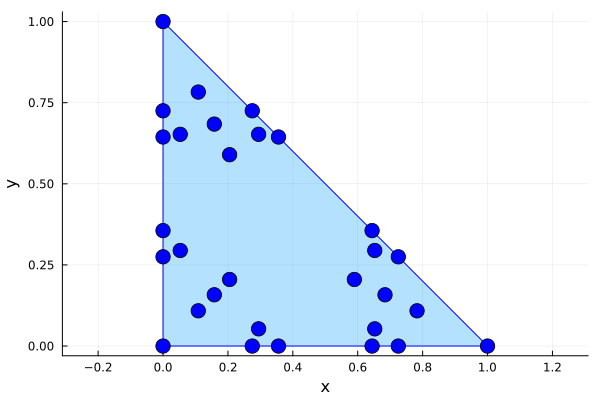

In [4]:
# Define the bounds
# lower_bounds = BigFloat[0.0, 0.0, 0.0]
# upper_bounds = BigFloat[1, 1, 1]
# initial_value = BigFloat[0.1, 0.1, 0.2]

min_val = 0.1
max_val = 0.5
a = min_val .+ (max_val - min_val) .* BigFloat.(rand(freeparam))

# a = BigFloat[0.01, 0.01, 0.02]
# a = BigFloat[0.1, 0.1, 0.2] # works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32] #works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32]

print(a)

#########################################################################################################################
# Plotting initial distribution
#########################################################################################################################
using Plots
plot()
# gr()  # Set the backend to GR

# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")
#########################################################################################################################

In [5]:
println(a)

td = TwiceDifferentiable(f, a; autodiff = :forward);

println("done with td!")

# result = optimize(td, a, Newton(; linesearch = LineSearches.MoreThuente()), Optim.Options(g_tol = 1e-100, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))
# result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-15, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))

result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(f_tol = 1e-15, iterations = 30, show_trace = true, show_every = 1, time_limit = 1000))

println(result)

#
# # Set up the optimization problem with bounds
# # result = optimize(f, lower_bounds, upper_bounds, BigFloat[0.1, 0.1, 0.2], Fminbox(NelderMead()), Optim.Options(g_tol = 1e-63, iterations = 100_000, show_trace = false))
# result = optimize(f,
#             lower_bounds,
#             upper_bounds,
#             init_guess,
#             Fminbox(NelderMead()),
#             Optim.Options(g_tol = 1e-15, iterations = 100_000, show_trace = true, show_every = 100)
#             )
#

a = Optim.minimizer(result)

In [ ]:
a = Optim.minimizer(result)

In [ ]:
(A(a,order) * A(a,order)')\(A(a,order) * rhs(order))

In [ ]:
f(a)

In [ ]:
using Plots
# gr()  # Set the backend to GR
plot()
# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[5],a[6])[1, :], T6(a[5],a[6])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")

In [ ]:
println(T1)

println(T4(a[1]))
println(T4(a[2]))

println(T5(a[3]))
println(T5(a[4]))
println(T5(a[5]))